# Training a Food Image Classfier

In this notebook, we will train a Resnet-50 CNN on the [Food-101 dataset](https://www.vision.ee.ethz.ch/datasets_extra/food-101/).

The dataset included 101 food categories with each class having 1000 images.aa

# Imports

Import the fastai library and other dependencies



In [1]:
import pandas as pd
import requests
import glob
from io import BytesIO
import numpy as np
import os
import shutil
import pprint
import json

In [2]:
from fastai import *
from fastai.vision import *

# Load Data

In [3]:
path = Path('../data/food-101/images')


Create image iterator on the folder of images..
- resize image to 128 
- split 80/20 image 
- apply image transformations
- load 64 images in batch

In [4]:
data = ImageDataBunch.from_folder(path, valid_pct=0.2,
        ds_tfms=get_transforms(), size=128, num_workers=8, bs=64).normalize(imagenet_stats)


In [5]:
print (f"There are {len(data.train_ds)} images.. ")  
print (f"train: {len(data.train_ds)}, valid: {len(data.valid_ds)}   ")
print (f"There are {data.c} classes")



There are 80800 images.. 
train: 80800, valid: 20200   
There are 101 classes


Some of the classes

In [6]:
data.classes

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

# Explore Data

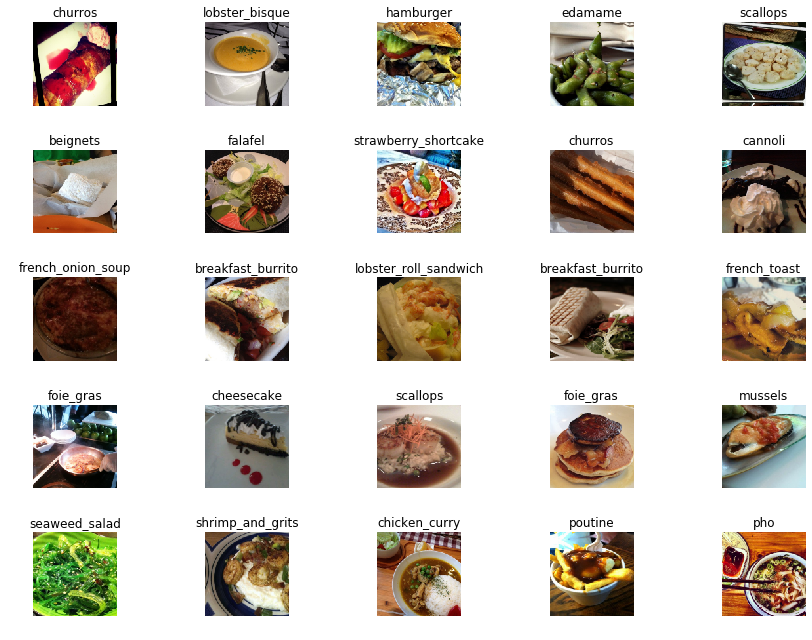

In [7]:
data.show_batch(rows=5, figsize=(12, 9))


# Training model

Lets use Convolutional Neural Networks (CNN).    
Training a CNN from scratch can be time consuming.   
Lets insttead use transfer learning.    
We will use a resnet 50 model trained on ImageNet dataset 

WE will calculate `error_rate` , `accuracy`, `top_k_accuracy` .  

Fastai makes creating a cnn with finetuning easy

In [8]:
?cnn_learner

Signature:
cnn_learner(
    data: fastai.basic_data.DataBunch,
    base_arch: Callable,
    cut: Union[int, Callable] = None,
    pretrained: bool = True,
    lin_ftrs: Union[Collection[int], NoneType] = None,
    ps: Union[float, Collection[float]] = 0.5,
    custom_head: Union[torch.nn.modules.module.Module, NoneType] = None,
    split_on: Union[Callable, Collection[Collection[torch.nn.modules.module.Module]], NoneType] = None,
    bn_final: bool = False,
    init=<function kaiming_normal_ at 0x7f99ae11c6a8>,
    concat_pool: bool = True,
    **kwargs: Any,
) -> fastai.basic_train.Learner
Docstring: Build convnet style learner.
File:      /opt/anaconda3/lib/python3.7/site-packages/fastai/vision/learner.py
Type:      function


In [9]:
learn = cnn_learner(data = data, base_arch=models.resnet50
                    , metrics=[error_rate,accuracy,top_k_accuracy]
                    , pretrained=True)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


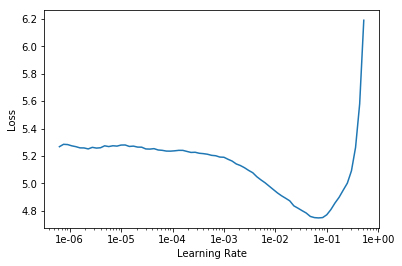

In [10]:
learn.lr_find() # find learning rate
learn.recorder.plot() # plot learning rate

In [11]:
lr = 1e-2  # chosen learning rate

In [ ]:
learn.fit_one_cycle(6 , lr)  # train model for 4 epochs

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,2.330750,2.266057,0.568218,0.431782,0.717376,05:08
1,2.185016,2.065215,0.526535,0.473465,0.757178,05:10
2,1.951524,1.680946,0.439802,0.560198,0.822475,05:11
3,1.701247,1.444541,0.376782,0.623218,0.855693,05:11
4,1.484084,1.278172,0.335644,0.664356,0.880000,05:11


In [13]:
model_name="resnet50"

In [14]:
learn.save(f'stage-1')

In [16]:
learn.load(f'stage-1');

The above code didn't train the full network.. only the last layers    
In order to train the full network, we need to `unfreeze`.     

We also want our earlier layers to learn/change at a lower rate. So we choose a lower lr    

In [17]:
learn.unfreeze()

In [18]:
learn.lr_find(start_lr=1e-09, end_lr=1e-3)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


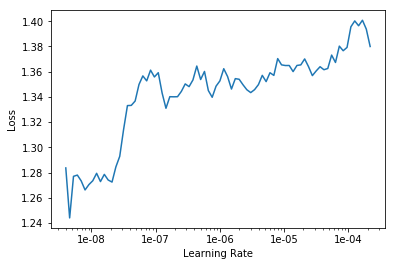

In [19]:
learn.recorder.plot(skip_end=10)


In [20]:
learn.fit_one_cycle(5, max_lr=slice(1e-8,1e-4))


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.348365,1.230928,0.325495,0.674505,0.886089,05:21
1,1.323330,1.217410,0.321634,0.678366,0.888168,05:17
2,1.324026,1.213655,0.321238,0.678762,0.888663,05:20
3,1.331518,1.208734,0.318960,0.681040,0.890149,05:20
4,1.309689,1.208218,0.320198,0.679802,0.889852,05:19


In [21]:
learn.save(f'stage-2')


# Training model: part 2 


Our model was trained on 128 image size (lower resolution).    
One way to improve the model better is to now use the model on the normal size resolution

In [22]:
# switch resolution
data = ImageDataBunch.from_folder(path, valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=8, bs=64).normalize(imagenet_stats)


learn.data = data



In [23]:
# freeze bottom layers again,
learn.freeze() 


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


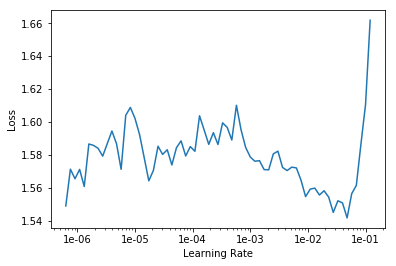

In [24]:
learn.lr_find()
learn.recorder.plot(skip_end=10)

In [ ]:
lr = 1e-2
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.413502,1.263668,0.337277,0.662723,0.884901,08:10
1,1.606014,1.377446,0.365941,0.634059,0.867178,08:06


In [ ]:
learn.save('stage-3')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-8,1e-4))

learn.save('stage-4')

# Interpretation

In [ ]:
learn.load(f'stage-4');


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)


In [ ]:
interp.plot_top_losses(9, figsize=(15,11))


In [ ]:
interp.plot_confusion_matrix(figsize=(50,50), dpi=30)


In [ ]:
interp.most_confused(min_val=2)


In [ ]:
learn.save('final')


In [ ]:
learn.export("models/final.pkl")